Reprojecting SunPy maps from one reference frame to another is most commonly done with [full-disk images](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html#sphx-glr-generated-gallery-map-transformations-reprojection-different-observers-py). The built-in implementation of _reproject_to()_ is also capable of reprojecting submaps or cutouts; however, unless the output WCS are carefully adjusted this is just as slow as reprojecting a full-disk image.

To adjust the output WCS to match the size of the reprojected cutout - and therefore to execute _reproject_ without a potentially 4k x 4k array - the CRPIX keywords must be adjusted to account for the new origin in the desired output matrix shape.

This example uses images from November 2021, when Solar Orbiter was close to the Earth and their fields-of-view were quite similar.

In [1]:
import pandas as pd
import sunpy.map
from stix_utils import load_SOLO_SPICE
from visible_from_earth import get_observer
from flare_physics_utils import cartesian_diff
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
%matplotlib notebook

In [3]:
peak_utc_corrected=pd.to_datetime('2021-11-02 07:45:11')
load_SOLO_SPICE(peak_utc_corrected)
sobs,swcs=get_observer(peak_utc_corrected,obs='SOLO',sc=True)



SPICE kernels loaded correctly



<IPython.core.display.Javascript object>


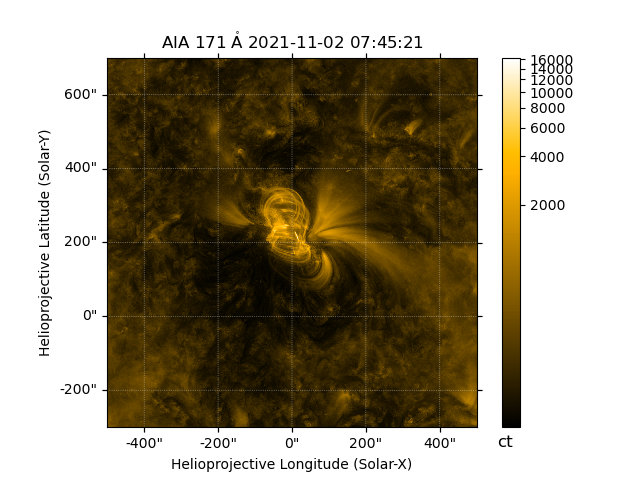

In [6]:
mcutout=sunpy.map.Map('aia.lev1_euv_12s.2021-11-02T074511Z.171.image._prepped.fits')
mcutout.peek()

To get the Solar Orbiter WCS, it is necessary to first load the proper SPICE kernels.

One can then reproject the AIA map to the Solar Orbiter viewpoint using the built-in _reproject_to():

In [7]:
%%time
mr=mcutout.reproject_to(swcs)

CPU times: user 29 s, sys: 10.5 s, total: 39.5 s
Wall time: 41 s


However, this is very slow! This is because the default size of the Solar Orbiter WCS array matches the full-disk AIA size of (4096,4096). A lot of time is wasted reprojecting NaNs.

To adjust the Solar Orbiter WCS, new CRPIX WCS keywords must be calculated. For this, two quantities are needed: A reference coordinate for the  Solar Orbiter coordinate frame, and the new size of the reprojected data array. A pixel scale factor is optional but not yet incorporated.

A reference coordinate is returned by _get_observer()_ if the argument _sc=True_, otherwise it can be constructed in the usual way of making a SkyCoord at (0",0") in the desired reference frame.

Next, find the extent of the new data array after reprojection (without doing the reprojection of course)!

In [10]:
blr=mcutout.bottom_left_coord.transform_to(sobs.frame)
trr=mcutout.top_right_coord.transform_to(sobs.frame)

If the rotation of either coordinate is not possible, NaN will be returned as either Tx or Ty. In that case, the extent of the new array can be found by transforming all the coordinates (it doesn't take as long as it sounds) and finding the on-disk boundaries of those coordinates. Note: It may be possible to extend the boundaries to off-disk with no negative consequences to _reproject_ but this hasn't been tested yet.

In [11]:
def rotated_bounds_on_disk(mcutout,frame):
    '''use this to determine extent of rotated shape in case bottom left and top right contain NaN'''
    cc=all_coordinates_from_map(mcutout).transform_to(frame)
    on_disk=sunpy.map.coordinate_is_on_solar_disk(cc)
    on_disk_coordinates=cc[on_disk] 
    tx = on_disk_coordinates.Tx.value
    ty = on_disk_coordinates.Ty.value
    return SkyCoord([np.nanmin(tx), np.nanmax(tx)] * u.arcsec,
                    [np.nanmin(ty), np.nanmax(ty)] * u.arcsec,
                    frame=smap.coordinate_frame)

if np.isnan([blr.Tx.value,blr.Ty.value]).any() or np.isnan([trr.Tx.value,trr.Ty.value]).any():
        blr,trr=rotated_bounds_on_disk(mcutout,sobs.frame)

In [12]:
width, height=cartesian_diff(blr,trr,index=1) #arcsec
out_shape=(int(width.value),int(height.value))

Sunpy maps index at 1, so if doing the difference by hand (trr.Tx-blr.Tx , etc) remember that _height_ and _width_ will need to be swapped from their usual indices in _out_shape_.

Make a new FITS header/WCS object for input to _reproject_:

In [13]:
submap_header=sunpy.map.make_fitswcs_header(out_shape,sobs,instrument="STIX",observatory="Solar Orbiter") 

This will NOT account for the translation of the cutout (CRPIX), so that will need to be added by hand. Additionally, the distance between the observer and the Sun will still be at the default 1AU, so this needs to be updated as well.

Calculate the offset between the full-disk (0",0") pixel (_swcs.wcs.crpix_) and the bottom-left corner of the cutout in pixels (_swcs.world_to_pixel(blr)_):

In [14]:
scrpix=swcs.wcs.crpix-swcs.world_to_pixel(blr)

Update the CRPIX and dsun_obs keywords in the header dictionary, and then do the reprojection:

In [15]:
submap_header['crpix1']=scrpix[0]
submap_header['crpix2']=scrpix[1]
submap_header['dsun_obs']=swcs.wcs.aux.dsun_obs
rotated_map = mcutout.reproject_to(submap_header)

<IPython.core.display.Javascript object>


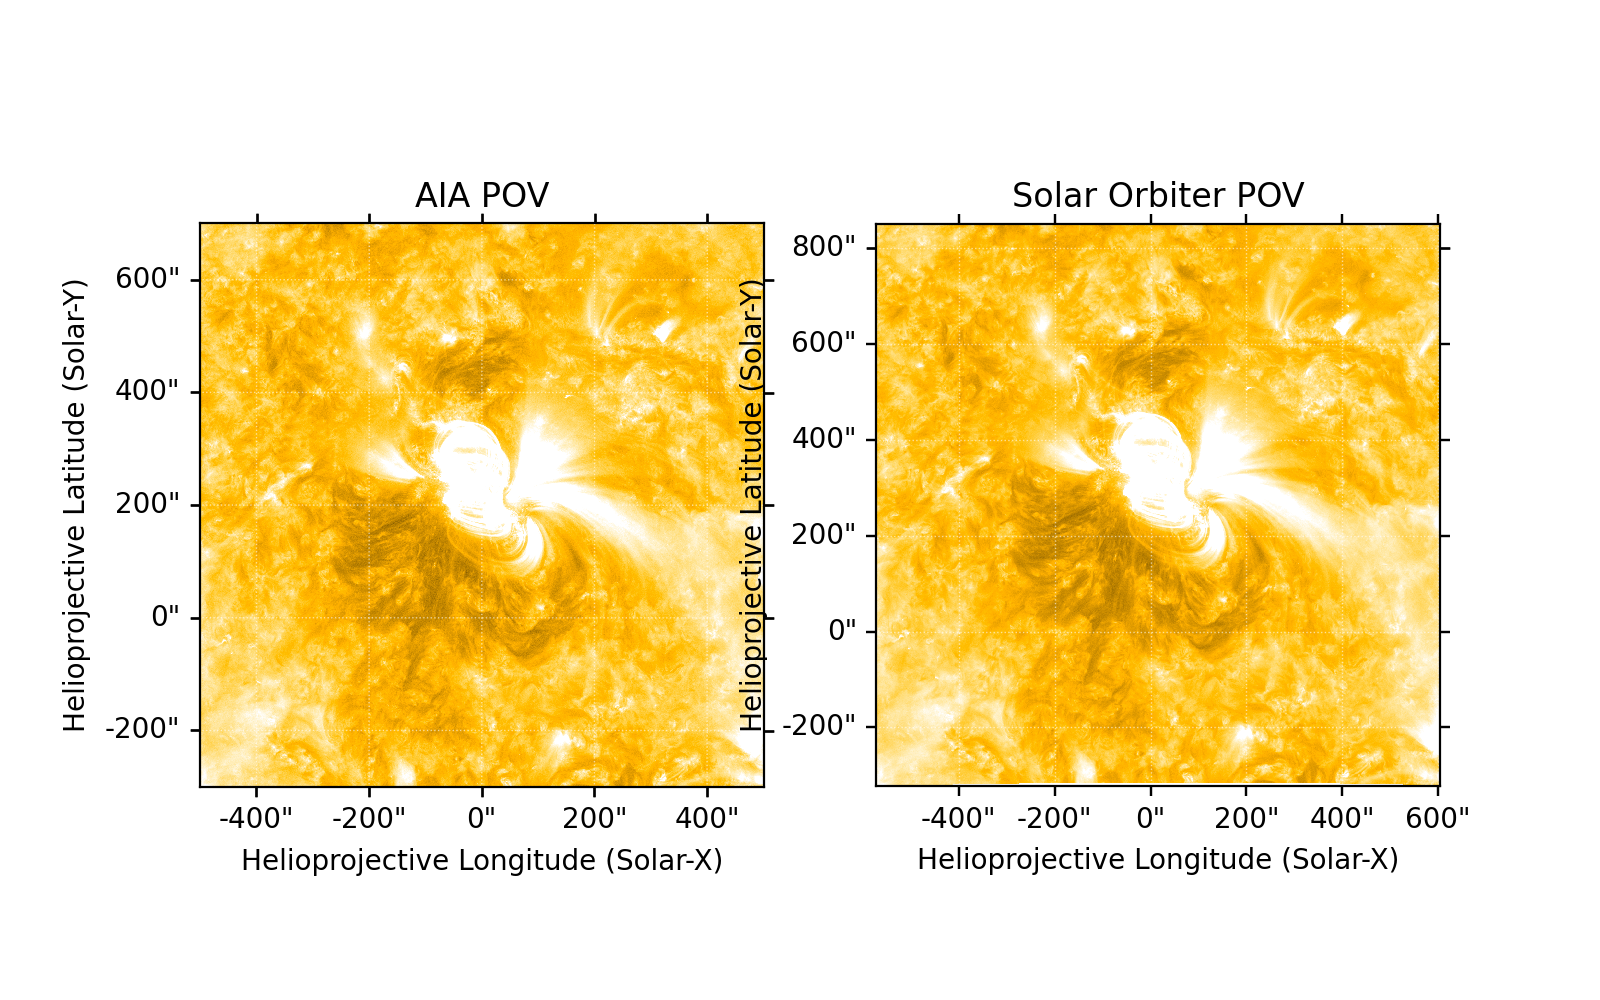

Text(0.5, 1.0, 'Solar Orbiter POV')

In [16]:
fig=plt.figure(figsize=(8,5))
ax0=fig.add_subplot(1,2,1,projection=mcutout)
mcutout.plot(axes=ax0,vmin=0,vmax=500)
ax0.set_title('AIA POV')
ax1=fig.add_subplot(1,2,2,projection=rotated_map)
rotated_map.plot(axes=ax1,vmin=0,vmax=500,cmap='sdoaia171')
ax1.set_title('Solar Orbiter POV')

This results in a speed-up of 8-9x for this 1000" x 1000" cutout.

In [17]:
def smart_reproject(mcutout,sobs,instrument='STIX',observatory='Solar Orbiter'):
    blr=mcutout.bottom_left_coord.transform_to(sobs.frame)
    trr=mcutout.top_right_coord.transform_to(sobs.frame)
    if np.isnan([blr.Tx.value,blr.Ty.value]).any() or np.isnan([trr.Tx.value,trr.Ty.value]).any():
        blr,trr=rotated_bounds_on_disk(mcutout,sobs.frame)
    width, height=cartesian_diff(blr,trr,index=1) #arcsec
    out_shape=(int(width.value),int(height.value))
    submap_header=sunpy.map.make_fitswcs_header(out_shape, sobs,
                                      #scale=scale,
                                      instrument=instrument,observatory=observatory)
    scrpix=swcs.wcs.crpix-swcs.world_to_pixel(blr)
    submap_header['crpix1']=np.round(scrpix[0],1)
    submap_header['crpix2']=np.round(scrpix[1],1)
    submap_header['dsun_obs']=swcs.wcs.aux.dsun_obs
    rotated_map=mcutout.reproject_to(submap_header)
    return rotated_map

In [18]:
%%timeit
rotated_map=smart_reproject(mcutout,sobs)


2.74 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
